In [1]:
import sys, os, sys
from pathlib import Path
from jfi import jaxm
import torch, matplotlib.pyplot as plt, numpy as np

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))

from pmpc.experimental import solve as solve_jax
from pmpc import solve as solve_cpu

here_path = Path("").absolute()
if str(here_path) not in sys.path:
    sys.path.append(str(here_path))

from dubins_car import f_np as f_fn, fx_np as fx_fn, fu_np as fu_fn

In [2]:
M, N, xdim, udim = 1, 30, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(0. * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_l, u_u = -1 * np.ones((N, udim)), 1 * np.ones((N, udim))

X_ref = 0.4 * np.ones_like(X_ref)

In [3]:
def f_fx_fu_fn(X_prev, U_prev):
    x, u, p = X_prev, U_prev, np.array([1.0, 1.0, 0.3])
    return (
        f_fn(np.asarray(x), np.asarray(u), p),
        fx_fn(np.asarray(x), np.asarray(u), p),
        fu_fn(np.asarray(x), np.asarray(u), p),
    )


def quadratic_cost(X, U):
    X_ref_t = torch.tensor(X_ref)
    c = 0.5 * torch.square(X - X_ref_t).sum(-1).sum(-1)
    return c


def cost_fn(X, U):
    with torch.no_grad():
        if not isinstance(X, torch.Tensor):
            X = torch.as_tensor(np.array(X), dtype=torch.float32)
            U = torch.as_tensor(np.array(U), dtype=torch.float32)

        z = torch.concatenate([X, U], axis=-1)
        J = torch.autograd.functional.jacobian(
            lambda X: quadratic_cost(X, U), X, create_graph=False
        )
        cx = J[0, ..., :xdim]
        cu = J[0, ..., xdim:]
        return cx.detach(), None  # cu.detach()

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  2.246e+01 |  1.159e+00 |  1.944e+00 |  1.000e+00 |  1.000e-02 |
| 0002 |  2.247e+01 |  7.583e-01 |  5.468e-01 |  1.000e+00 |  1.000e-02 |
| 0003 |  2.248e+01 |  7.180e-01 |  2.838e-01 |  1.000e+00 |  1.000e-02 |
| 0004 |  2.249e+01 |  7.010e-01 |  2.066e-01 |  1.000e+00 |  1.000e-02 |
| 0005 |  2.250e+01 |  6.969e-01 |  1.123e-01 |  1.000e+00 |  1.000e-02 |
| 0006 |  2.251e+01 |  6.958e-01 |  5.848e-02 |  1.000e+00 |  1.000e-02 |
| 0007 |  2.252e+01 |  6.956e-01 |  2.873e-02 |  1.000e+00 |  1.000e-02 |
| 0008 |  2.253e+01 |  6.955e-01 |  1.359e-02 |  1.000e+00 |  1.000e-02 |
| 0009 |  2.254e+01 |  6.955e-01 |  6.165e-03 |  1.000e+00 |  1.000e-02 |
| 0010 |  2.255e+01 |  6.955e-01 |  2.750e-03 |  1.000e+00 |  1.000e-02 |
| 0011 |  2.256e+01 |  6.955e-01 |  1.

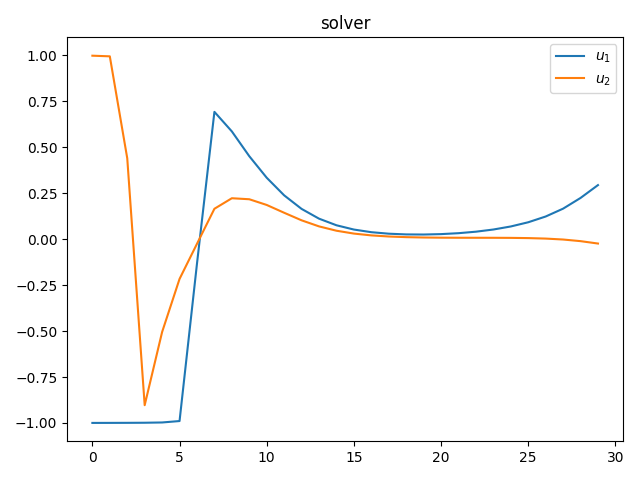

+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+


/home/rdyro/Dropbox/stanford/sensitivity_analysis/pmpc/tests/dubins_car.py:34: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  args = torch.as_tensor(x), torch.as_tensor(u), torch.as_tensor(p)


| 0001 |  2.974e+00 |  1.561e+00 |  1.944e+00 |  1.0e+00 |  1.0e-02 |  1.0e+03 |
| 0002 |  3.009e+00 |  4.220e-01 |  6.966e-01 |  1.0e+00 |  1.0e-02 |  1.0e+03 |
| 0003 |  3.032e+00 |  3.470e-01 |  3.038e-01 |  1.0e+00 |  1.0e-02 |  1.0e+03 |
| 0004 |  3.055e+00 |  3.274e-01 |  2.012e-01 |  1.0e+00 |  1.0e-02 |  1.0e+03 |
| 0005 |  3.078e+00 |  3.232e-01 |  1.118e-01 |  1.0e+00 |  1.0e-02 |  1.0e+03 |
| 0006 |  3.100e+00 |  3.221e-01 |  5.839e-02 |  1.0e+00 |  1.0e-02 |  1.0e+03 |
| 0007 |  3.123e+00 |  3.219e-01 |  3.157e-02 |  1.0e+00 |  1.0e-02 |  1.0e+03 |
| 0008 |  3.146e+00 |  3.218e-01 |  1.948e-02 |  1.0e+00 |  1.0e-02 |  1.0e+03 |
| 0009 |  3.169e+00 |  3.218e-01 |  1.220e-02 |  1.0e+00 |  1.0e-02 |  1.0e+03 |
| 0010 |  3.192e+00 |  3.218e-01 |  7.707e-03 |  1.0e+00 |  1.0e-02 |  1.0e+03 |
| 0011 |  3.214e+00 |  3.218e-01 |  4.891e-03 |  1.0e+00 |  1.0e-02 |  1.0e+03 |
| 0012 |  3.237e+00 |  3.218e-01 |  3.112e-03 |  1.0e+00 |  1.0e-02 |  1.0e+03 |
| 0013 |  3.260e+00 |  3.218

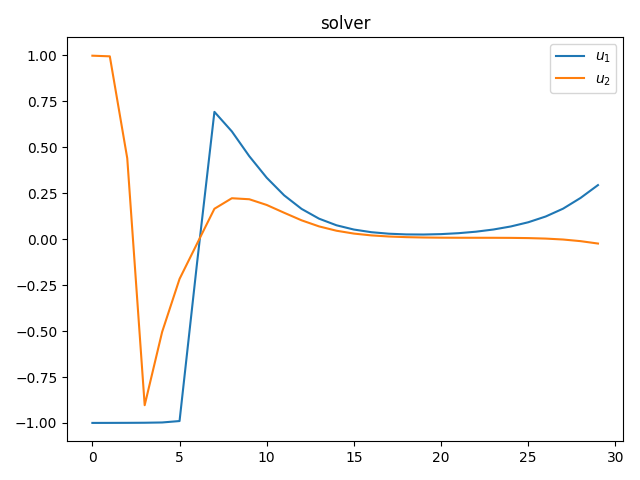

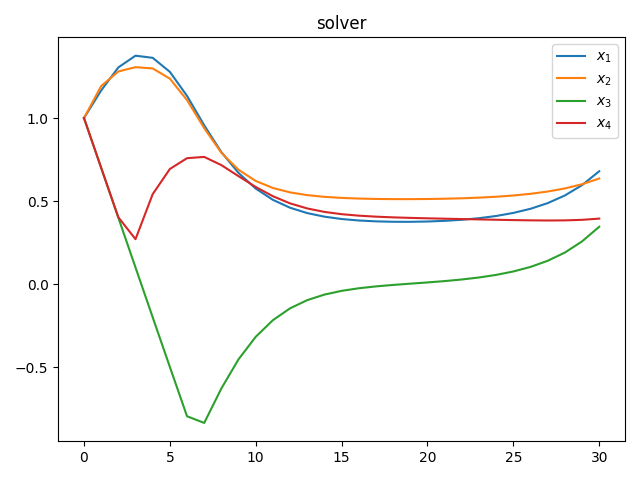

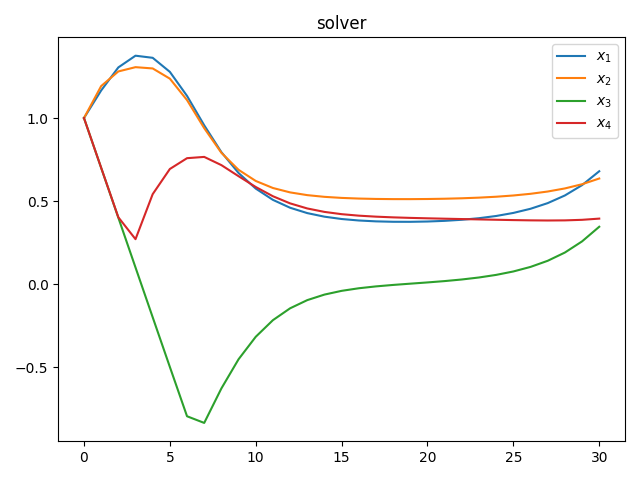

In [4]:
## Convex Cost
Xs, Us = [], []
for solve in [solve_cpu, solve_jax]:
    if solve is solve_jax:
        opts = dict(verbose=True, u_l=u_l, u_u=u_u, device='cpu', dtype=jaxm.float64)
        opts["solver_settings"] = dict(smooth_alpha=1e3)
    else:
        opts = dict(verbose=True, u_l=u_l, u_u=u_u)
        opts["solver_settings"] = dict(smooth_cstr="logbarrier", smooth_alpha=1e3)
    args = (f_fx_fu_fn, Q, R, x0, X_ref, U_ref, X_prev, U_prev)

    X, U, data = solve(*args, max_it=100, **opts)
    Xs.append(X)
    Us.append(U)

    plt.figure()
    plt.title('solver')
    for r in range(xdim):
        plt.plot(X[:, r], label="$x_%d$" % (r + 1))
    plt.legend()
    plt.tight_layout()

    plt.figure()
    plt.title('solver')
    for r in range(udim):
        plt.plot(U[:, r], label="$u_%d$" % (r + 1))
    plt.legend()
    plt.tight_layout()

    plt.show()

In [5]:
jaxm.norm(Xs[0] - Xs[1]) / jaxm.norm(Xs[0])

Array(3.04271668e-06, dtype=float64)

{'verbose': True, 'u_l': array([[-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.]]), 'u_u': array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
     

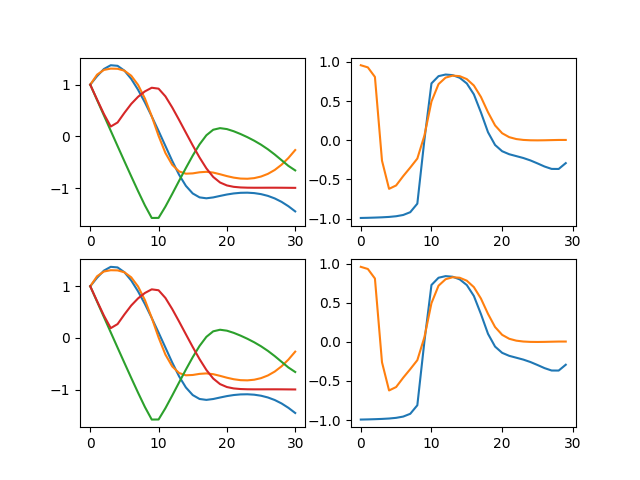

In [6]:
## External Cost
Xs, Us = [], []
#ecost = lambda X, U, *args, **kw: cost_fn(X, U)
ecost = lambda X, U, *args, **kw: (jaxm.ones(X.shape), None)
#ecost = lambda X, U, *args, **kw: (None, None)
X_ref_inp = np.zeros_like(X_ref)
fig, ax = plt.subplots(2, 2)

opts = dict(verbose=True, u_l=u_l, u_u=u_u, reg_x=3e0, reg_u=1e0, lin_cost_fn=ecost)
opts["solver_settings"] = dict(smooth_alpha=1e1)
#Q = 1e-5 * jaxm.tile(jaxm.eye(Q.shape[-1]), (N, 1, 1))
Q = jaxm.tile(jaxm.eye(Q.shape[-1]), (N, 1, 1))
args = (f_fx_fu_fn, Q, R, x0, X_ref_inp, U_ref, X_prev, U_prev)

for (i, solve) in enumerate([solve_cpu, solve_jax]):
    if solve is solve_jax:
        opts = dict(opts, device="cpu", dtype=jaxm.float64)
    print(opts)
    X, U, data = solve(*args, max_it=100, **opts)
    Xs.append(X)
    Us.append(U)

    for r in range(xdim):
        ax[i, 0].plot(X[:, r], label="$x_%d$" % (r + 1))
    for r in range(udim):
        ax[i, 1].plot(U[:, r], label="$u_%d$" % (r + 1))

plt.show()

In [7]:
jaxm.norm(Xs[0] - Xs[1]) / jaxm.norm(Xs[0])

Array(6.60853654e-05, dtype=float64)

In [ ]:
cache = dict()

def wrapper(alpha):
    opts = dict(verbose=True, u_l=u_l, u_u=u_u, reg_x=1e0, reg_u=1e0)
    #opts = dict(opts, cost_fn=ecost)
    opts["solver_settings"] = dict(smooth_alpha=float(alpha))
    #Q_ = 1e-5 * jaxm.tile(jaxm.eye(Q.shape[-1]), (N, 1, 1))
    Q_ = Q
    args = (f_fx_fu_fn, Q_, R, x0, X_ref_inp, U_ref, X_prev, U_prev)
    X, U, data = solve(*args, max_it=100, **opts)
    obj = np.linalg.norm(X - np.array(Xs[1]))
    print(f"Alpha = {float(alpha):.4e}")
    cache[float(alpha)] = obj
    return obj

from scipy.optimize import minimize

def cb(*args, **kw):
    objs = list(cache.values())
    print(f"Best obj = ({min(objs):.4e}")

def binary_min(f, a, b, tol=1e-5):
    fa, fb = f(a), f(b)
    while abs(a - b) > tol:
        c = (a + b) / 2
        if fb < fa:
            a, fa = c, f(c)
        else:
            b, fb = c, f(c)
    return (a + b) / 2

#alpha_star = minimize(wrapper, 1e3, method="Nelder-Mead", callback=cb, options=dict(maxiter=10)).x
alpha_star = binary_min(wrapper, 1e2, 1e3)

In [ ]:
alphas = np.logspace(1, 3, 30)
fs = [wrapper(alpha) for alpha in alphas]

In [ ]:
plt.figure()
plt.semilogx(alphas, fs, marker=".")
plt.show()

In [ ]:
x, y = np.array(list(cache.keys())), np.array(list(cache.values()))
idx = np.argsort(x)
plt.figure()
plt.semilogx(x[idx], y[idx], marker=".")

In [ ]:
alpha_star

In [ ]:
wrapper(alpha_star)